# Chest X-Ray Images Detecting Pneumonia in Pediatric Patients
Here we will detect whether or not a pediatric patient has pneumonia. This will be done through Convolutional Neural Networking. (CNN)

The method of completing this task is as follows 
    - loading images from a dataset obtained by [I'm an inline-style link](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) 
    - augment the image data to train the neural network 
    - build a CNN using Keras

### Importing the necessary libraries, tools and models

In [139]:
#import necessary library and tools
import pandas as pd 

import matplotlib.pyplot as plt 
%matplotlib inline

import scipy
from scipy import ndimage

import numpy as np 
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.models import load_model
from keras.models import Sequential

from keras.layers import Flatten
from keras.layers import MaxPool2D
from keras.layers import MaxPooling2D
from keras.layers import Reshape
from keras.layers import Dropout


from keras.optimizers import SGD, Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import metrics
from sklearn.metrics import roc_curve

np.random.seed(123)
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os, shutil 

# Exploratory Data Analysis

In [3]:
!ls #here I am looking at the repository structure

README.md        baseline_cnn1.h5 data             stakeholder_memo
baseline_cnn.h5  cnn.ipynb        split


In [4]:
!ls split/train/NORMAL *.jpeg | wc #let's see how many images are in the normal train set

ls: *.jpeg: No such file or directory
    1342    1342   30775


In [5]:
!ls split/train/PNEUMONIA *.jpeg | wc #the number of images in the train set that show each pediatric patient has 
#pneumonia

ls: *.jpeg: No such file or directory
    3876    3876  108710


There is a class imbalance within the train dataset, will need to pass class weights into model!

In [6]:
!cd split/train/NORMAL; ls #here we are making sure that each photo is actually read in. I did cd train/NORMAL
# ; ls -lq *.jpeg | wc -1 and it said that there were no images within the file(s) listed 

IM-0115-0001.jpeg              NORMAL2-IM-0478-0001.jpeg
IM-0117-0001.jpeg              NORMAL2-IM-0479-0001.jpeg
IM-0119-0001.jpeg              NORMAL2-IM-0480-0001.jpeg
IM-0122-0001.jpeg              NORMAL2-IM-0481-0001.jpeg
IM-0125-0001.jpeg              NORMAL2-IM-0482-0001.jpeg
IM-0127-0001.jpeg              NORMAL2-IM-0485-0001.jpeg
IM-0128-0001.jpeg              NORMAL2-IM-0486-0001.jpeg
IM-0129-0001.jpeg              NORMAL2-IM-0487-0001.jpeg
IM-0131-0001.jpeg              NORMAL2-IM-0488-0001.jpeg
IM-0133-0001.jpeg              NORMAL2-IM-0489-0001.jpeg
IM-0135-0001.jpeg              NORMAL2-IM-0490-0001.jpeg
IM-0137-0001.jpeg              NORMAL2-IM-0491-0001.jpeg
IM-0140-0001.jpeg              NORMAL2-IM-0493-0001.jpeg
IM-0141-0001.jpeg              NORMAL2-IM-0496-0001.jpeg
IM-0143-0001.jpeg              NORMAL2-IM-0497-0001.jpeg
IM-0145-0001.jpeg              NORMAL2-IM-0499-0001.jpeg
IM-0147-0001.jpeg              NORMAL2-IM-0500-0001.jpeg
IM-0149-0001.jpeg              

In [7]:
#here we are instantiating ImageDataGenerator, this will do multiple tasks: 
# rescale will scale all of the pixels to one common size this will be done with 1./255
# the images will come from 'split/train' and is read into the directory parameter
#we are doing batch sizes of 32, I was advised that batch sizes that are less than 100 work relatively quickly
#the seed shuffles the transformation in a random manner, but the number is the same so that it can be reproduceable 

data_gen = ImageDataGenerator(rescale= 1./255).flow_from_directory(
                directory = 'split/train/', 
                batch_size = 2000, 
                seed=123)

Found 5216 images belonging to 2 classes.


In [8]:
# Now we inspect our output by running the data_gen just once and then getting the shapes
images, labels = next(data_gen)

In [9]:
images.shape #the batch size is 2000, the height and width is 256 and the 3 represents the RGB

(2000, 256, 256, 3)

In [10]:
labels #the labels show that this is a binary classification, because it is binary we only really need one column not 2

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [11]:
labels = np.reshape(labels[:,0],
                    (2000,1)) #we shape to make the labels one column/array

In [12]:
labels #now we can see that the 0 or 1 is a binary classification, 1 being PNUEMONIA and 0 being NORMAL

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

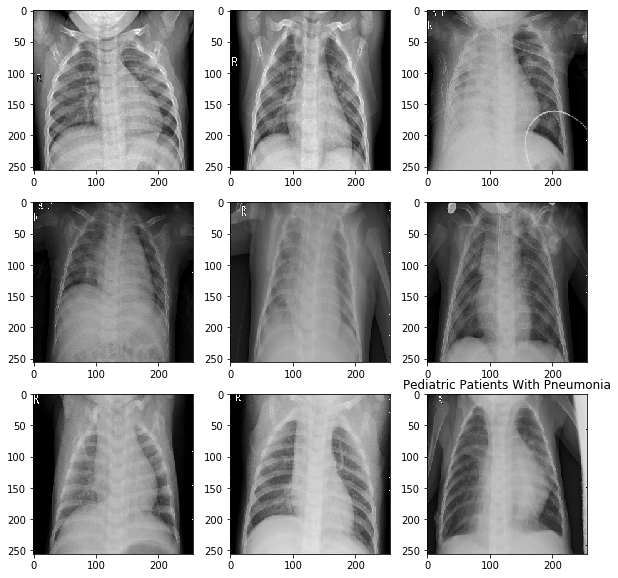

In [13]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(images[i])
plt.title('Pediatric Patients With Pneumonia')
plt.show()
#add labels
#here is a graphical representation of pediatric patients with pneumonia 

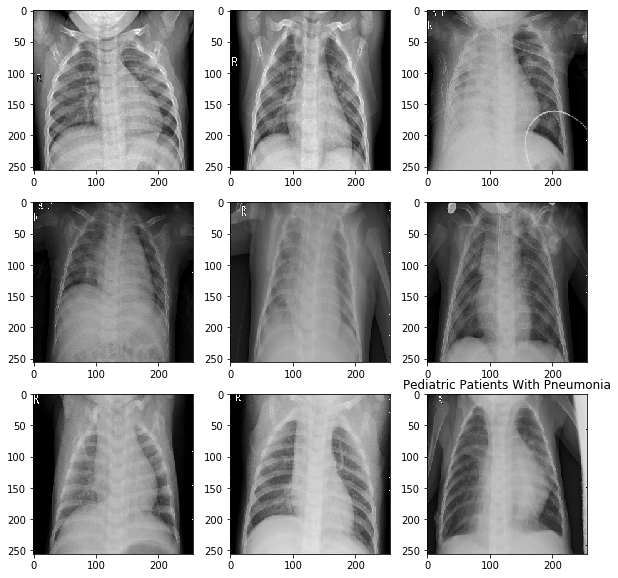

In [14]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(images[i])
plt.title('Pediatric Patients With Pneumonia')
plt.show()
#add labels
#here is a graphical representation of pediatric patients with pneumonia 

In [15]:
# Need to do our test train split to get train, val and test data. We can set the test folder to one side for nwo 

X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=.20, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=.20, random_state=1)

In [16]:
X_train.shape #looking at the shape (height x width) of the image(s) 

(1280, 256, 256, 3)

In [17]:
y_train[:10] #here we are looking at the columns in the array, it is already 1, so no need to one hot encode

array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.]], dtype=float32)

In [18]:
y_train.shape #another way to look at the array shape

(1280, 1)

# Best Practices

CNN layers: use small kernels/filters: 
 - 3x3 or 5x5
Use small strides 
 - 1 or 2 respectively 
Pooling Layers
 Downsampling 
 -use small kernels
 - 2x2 sometimes even 3x3 to reduce performance heavily 
Use small strides 
 - 2, rarely 3
Flattening Layers
 - transform multidimensional data into the NN into an array that can be used by a dense layer


# Building the baseline model 

In [19]:
#our baseline is going to start out big, which is why we are using 64 nodes,
#the middle convolutional layer will be 32 nodes
#next it is extremely important to flatten so that when we fit the baseline it will take in the right tensor shape
cnn = Sequential()

cnn.add(layers.Conv2D(64, kernel_size=(3,3), strides=2, input_shape=(256,256,3), activation='relu')) #conv layer
cnn.add(layers.MaxPooling2D(pool_size=(2,2), strides=2)) #adding a pooling layer

cnn.add(layers.Conv2D(32, kernel_size=(3,3), strides=2, input_shape=(256,256,3), activation='relu')) #conv layer
cnn.add(layers.MaxPooling2D(pool_size=(2,2), strides=2)) #adding a second pooling layer

cnn.add(Flatten()) #flatten tensor, this is extremely important as the following cell to fit validate 
#model will not work without flattening 

#dense layer for our problem
cnn.add(layers.Dense(1, activation='sigmoid'))

cnn.compile(loss='binary_crossentropy', 
           optimizer='adam',
           metrics=['acc'])

In [20]:
#lets look at our model
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 127, 127, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7201      
Total params: 27,457
Trainable params: 27,457
Non-trainable params: 0
__________________________________________________

## Back propogration for baseline model

In [21]:
#fit validate model to the training data for 10 epochs, doing back propogation with the same batch size as above
#also using our validation data set as well for validation 
history = cnn.fit(X_train, #using X_train images
                  y_train, #y_train images 
                  batch_size=32, #this represents the number of batches that the cnn will move in, 32
                  epochs=10, # we are using 10 epochs, this is when an entire dataset is passed forward and backward
                  #done 10 times 
                  validation_data= (X_val, y_val)) #validation data is obtained from the train test split

Train on 1280 samples, validate on 320 samples
Epoch 1/10
1280/1280 [==============================] - 29s 23ms/step - loss: 0.5428 - acc: 0.7523 - val_loss: 0.4828 - val_acc: 0.7031
Epoch 2/10
1280/1280 [==============================] - 20s 16ms/step - loss: 0.3030 - acc: 0.8672 - val_loss: 0.2392 - val_acc: 0.9250
Epoch 3/10
1280/1280 [==============================] - 22s 17ms/step - loss: 0.2517 - acc: 0.8891 - val_loss: 0.2559 - val_acc: 0.8906
Epoch 4/10
1280/1280 [==============================] - 20s 15ms/step - loss: 0.1816 - acc: 0.9336 - val_loss: 0.3590 - val_acc: 0.8625
Epoch 5/10
1280/1280 [==============================] - 23s 18ms/step - loss: 0.1488 - acc: 0.9414 - val_loss: 0.1793 - val_acc: 0.9375
Epoch 6/10
1280/1280 [==============================] - 28s 22ms/step - loss: 0.1214 - acc: 0.9594 - val_loss: 0.1517 - val_acc: 0.9344
Epoch 7/10
1280/1280 [==============================] - 23s 18ms/step - loss: 0.0874 - acc: 0.9664 - val_loss: 0.1431 - val_acc: 0.9469
E

In [22]:
cnn.save("baseline_cnn.h5") # in future if i don't want to train again, we can load 
#it from the folder using this kind of line
# model = load_model('model.h5')

## Visualizing Baseline Train/Val Loss and Accuracy

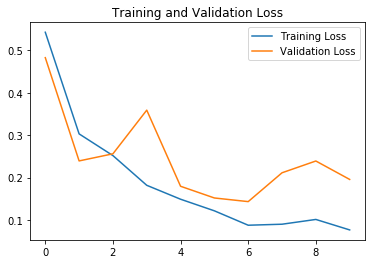

In [23]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

*** From this graph I can see that this model is overfit, this is seen through the validation loss being higher than the training loss. I now need to possibly do a drop out in the following model. ***

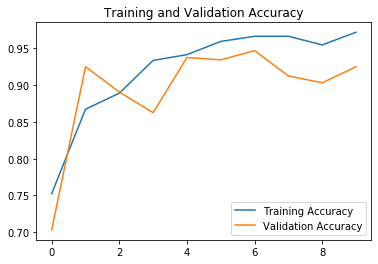

In [24]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()

*** Now we can see more of the overfitting, it isn't massive. But it is another way to double check the overfitting ***

# Build a Convolutional Neural Network

In [25]:
cnn1 = Sequential()

cnn1.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(256,256,3))) #input conv layer
cnn1.add(layers.MaxPooling2D((2,2))) #pooling layer 1

cnn1.add(layers.Conv2D(32, kernel_size=(4,4), activation='relu')) #hidden layer
cnn1.add(layers.MaxPooling2D((2,2))) #pooling layer 2

cnn1.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu')) #hidden layer
cnn1.add(layers.MaxPooling2D((2,2))) #pooling layer 3

cnn1.add(layers.Flatten()) #need to flatten y

cnn1.add(layers.Dense(64, activation='relu'))
cnn1.add(layers.Dense(1, activation='sigmoid'))

cnn1.compile(loss='binary_crossentropy', 
            optimizer='SGD',
            metrics=['acc'])


Here you can see that instead of using Adam I used SGD. 
Adam stands for Adaptive Moment Estimation and SGD stands for Stochastic Gradient Descent. It's not to say that one is better than the other which is why I decided to tune this model with SGD. 
Gradient descent is by far one of the simplest and oldest ways to optimise a deep learning neural network. It updates each parameter of the model, observes how it can effect other parts of the function and adapts to minimise the error and continues the process until its reach the global minimum. (As stated somewhere on this page I have had problems reaching the global minima). 
Adam is an algorithm for gradient based optimisation. It combines root mean square propogation and adaptive gradient algorithm to compute individual learning rates for different parameters. you can read up more on the difference between the two here, https://medium.com/syncedreview/iclr-2019-fast-as-adam-good-as-sgd-new-optimizer-has-both-78e37e8f9a34 

In [26]:
cnn1.summary() #this shows us every output of every layer. 
#As you can see the height and width are shrinking as we go deeper into the network
#as these shrink we can afford to add more layers
#the more layers we have the more accurate we can depict and identify patterns

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 124, 124, 32)      32800     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 28800)            

In [27]:
history1 = cnn1.fit(X_train,
                    y_train,
                    epochs = 30,
                    batch_size = 64,
                    validation_data = (X_val, y_val))
                    

Train on 1280 samples, validate on 320 samples
Epoch 1/30
1280/1280 [==============================] - 120s 94ms/step - loss: 0.5666 - acc: 0.7594 - val_loss: 0.5860 - val_acc: 0.7063
Epoch 2/30
1280/1280 [==============================] - 124s 97ms/step - loss: 0.5319 - acc: 0.7648 - val_loss: 0.5367 - val_acc: 0.7125
Epoch 3/30
1280/1280 [==============================] - 128s 100ms/step - loss: 0.4973 - acc: 0.7781 - val_loss: 0.4938 - val_acc: 0.8750
Epoch 4/30
1280/1280 [==============================] - 112s 88ms/step - loss: 0.5511 - acc: 0.7656 - val_loss: 0.6375 - val_acc: 0.7531
Epoch 5/30
1280/1280 [==============================] - 2074s 2s/step - loss: 0.4889 - acc: 0.7914 - val_loss: 0.6070 - val_acc: 0.6531
Epoch 6/30
1280/1280 [==============================] - 135s 106ms/step - loss: 0.4176 - acc: 0.8266 - val_loss: 0.5463 - val_acc: 0.7375
Epoch 7/30
1280/1280 [==============================] - 247s 193ms/step - loss: 0.4204 - acc: 0.8094 - val_loss: 0.7934 - val_acc:

In [28]:
cnn1.save("baseline_cnn1.h5") # in future if i don't want to rain again, we can load 
#it from the folder using this kind of line
# model = load_model('model.h5')

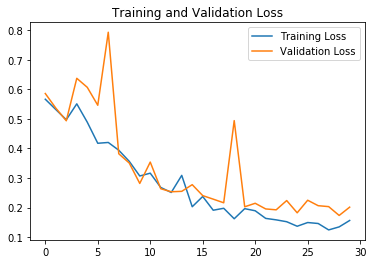

In [29]:
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

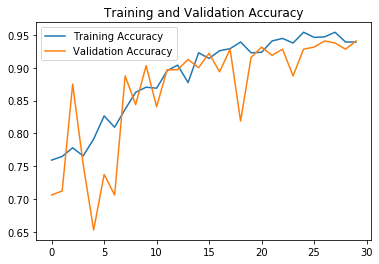

In [30]:
train_acc = history1.history['acc']
val_acc = history1.history['val_acc']
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()

*** Here you can see that the model is overfit only slightly, which is much better than before. I need to add dropout to reduce the problem of overfitting. ***

# Data Augmentation 

*** In the Exploratory Data Analysis section at the top we were able to spot a class imbalance in the train set. In order to fix this imbalance problem I have added a class weight dictionary. The 0 represents the normal x-rays with no signs of pneumonia. 2.89 is derived from (3876/1342). The 1 represents pediatric patients with pneumonia, since this far outweights the normal x-rays, we leave this at 1. This class weight dictionary will be passed in to the third convolutional neural network in order to help better fit and represent the data. ***

In [31]:
class_weight_dict = {0: 2.89, 1: 1} #fixing the class imbalance

*** Above we have a convolutional neural network that is better than the baseline. When we look at its train and validation loss and accuracy we can see that it performs better but overfits just slightly. Deep learning models, especially convolutional neural networks tend to overfit. We are going to use a regularisation method called 'Dropout' to simulate having a vast number of varying network architectures by dropping out nodes during training. ***

Below you can see that I have commented out two dropouts and one entire layer. When I was conducting data augmentation I had a repetitive problem of my validation accuracy getting stuck at a local minima. After looking at .summary() I also noticed that my params were set to 88m+ so in order to take this down in time and try to figure out a solution for eliminating the local minima I kept obtaining I have left my latest model as is. 
Another problem I used to solve this was to not use `SGD` as an optimiser. I also tried different learning weights which were not helpful. The default learning rate performs the best in my model. 

*** NOTE: Here I have mislabeled my cnn, it should say cnn3 instead of cnn2. While conducting data augmentation I had copied and pasted and retried a lot of steps in hope of going back and editing. I realised a little bit too late that I did not label the last and winning model accordingly. This goes to history and summary as well just below, it should have a 3 instead of 2. ***

In [32]:
cnn2 = Sequential()

# cnn2.add(Dropout(0.2, input_shape=(256,256,3)))
cnn2.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(256,256,3))) #input conv layer
cnn2.add(layers.MaxPooling2D((2,2)))

# cnn2.add(Dropout(0.2))
# cnn2.add(layers.Conv2D(32, kernel_size=(4,4), activation='relu')) #hidden layer
# cnn2.add(layers.MaxPooling2D((2,2)))

cnn2.add(Dropout(0.2))
cnn2.add(layers.Conv2D(16, kernel_size=(3,3), activation='relu')) #hidden layer
cnn2.add(layers.MaxPooling2D((2,2)))


cnn2.add(layers.Flatten()) #need to flatten y

cnn2.add(layers.Dense(16, activation='relu'))

cnn2.add(Dropout(0.2))
cnn2.add(layers.Dense(1, activation='sigmoid'))

#before compiling model let's tune SGD
sgd = SGD(lr=0.1, momentum=0.9)
adam = Adam(learning_rate=.001)

cnn2.compile(loss='binary_crossentropy', 
            optimizer=adam,
            metrics=['acc'])

cnn2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 16)      4624      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 61504)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)               

In [33]:
history2 = cnn2.fit(X_train,
                    y_train,
                    epochs = 30,
                    verbose = 1,
                    batch_size = 64,
                    class_weight = class_weight_dict,
                    validation_data = (X_val, y_val))


Train on 1280 samples, validate on 320 samples
Epoch 1/30
1280/1280 [==============================] - 113s 88ms/step - loss: 1.3752 - acc: 0.7203 - val_loss: 0.5962 - val_acc: 0.7063
Epoch 2/30
1280/1280 [==============================] - 82s 64ms/step - loss: 0.7427 - acc: 0.7594 - val_loss: 0.4983 - val_acc: 0.7188
Epoch 3/30
1280/1280 [==============================] - 82s 64ms/step - loss: 0.5596 - acc: 0.7789 - val_loss: 0.4604 - val_acc: 0.7188
Epoch 4/30
1280/1280 [==============================] - 82s 64ms/step - loss: 0.4076 - acc: 0.8398 - val_loss: 0.2941 - val_acc: 0.8906
Epoch 5/30
1280/1280 [==============================] - 83s 65ms/step - loss: 0.3858 - acc: 0.8625 - val_loss: 0.2717 - val_acc: 0.9031
Epoch 6/30
1280/1280 [==============================] - 82s 64ms/step - loss: 0.2510 - acc: 0.9055 - val_loss: 0.2742 - val_acc: 0.9000
Epoch 7/30
1280/1280 [==============================] - 83s 65ms/step - loss: 0.2444 - acc: 0.9023 - val_loss: 0.3351 - val_acc: 0.8625


Just by looking at this, I can see that it has performed better than my other two models. 

In [34]:
cnn2.save("baseline_cnn1.h5") # in future if i don't want to rain again, we can load 
#it from the folder using this kind of line
# model = load_model('model.h5')

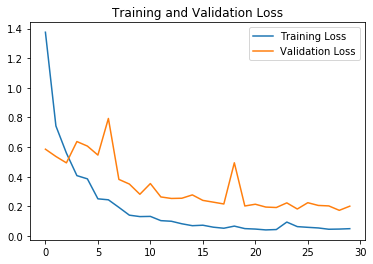

In [35]:
train_loss = history2.history['loss']
val_loss = history1.history['val_loss']
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

*** This model seems to be much better than the previous one conducted ***

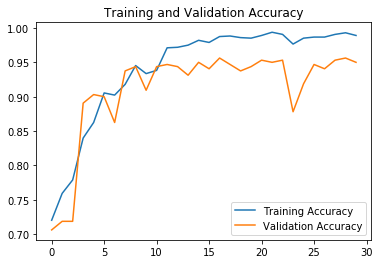

In [36]:
train_acc = history2.history['acc']
val_acc = history2.history['val_acc']
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()

The validation accuracy shows overfitting, compared to the train. 

Another method that is commonly used is to define each path, the img height and width and model just by pulling these as parameters

In [37]:
#test set 
data_gen_test = ImageDataGenerator(rescale= 1./255).flow_from_directory(
                directory = 'split/test/', 
                batch_size = 100, 
                seed=123)

Found 624 images belonging to 2 classes.


In [38]:
images, labels = next(data_gen_test)

In [39]:
images.shape

(100, 256, 256, 3)

In [40]:
labels

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.

In [41]:
labels = np.reshape(labels[:,0],
                    (100,1)) #we shape to make the labels one column/array

In [42]:
labels

array([[1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],

In [43]:
X_test.shape

(400, 256, 256, 3)

In [44]:
y_test.shape

(400, 1)

In [45]:
#need to see if there is an imbalance in the test set
!ls split/test/NORMAL *.jpeg | wc #let's see how many images are in the normal test set

ls: *.jpeg: No such file or directory
     235     235    5601


In [46]:
!ls split/test/PNEUMONIA *.jpeg | wc #let's see how many images are in the pneumonia test set

ls: *.jpeg: No such file or directory
     391     391   10415


In [47]:
#Not sure, but can add a class weight dict just in case
class_weight_dict_test = {0: 1.66, 1:1}

It seems to not have performed as well on the test set. 

*** This looks decent enough ***

### Now I will be doing a confusion matrix, prediction, threshold selection and specific loss and accuracy on the test set of the winning model

In [53]:
test_images, test_labels = next(data_gen_test)

In [54]:
test_images.shape[0]

100

In [61]:
m_test = test_images.shape[0]
print("test_images shape:" + str(test_images.shape))
print("test_labels shape:" + str(test_labels.shape))

test_images shape:(100, 256, 256, 3)
test_labels shape:(100, 2)


In [62]:
# test_img = test_images.reshape(test_images.shape[0], -1)
# print(test_img.shape)

In [63]:
test_y = np.reshape(test_labels[:,0], (100,1))

In [70]:
test_y.shape

(100, 1)

In [145]:
results_test = cnn2.evaluate(test_images, test_y)

100/100 [==============================] - 3s 32ms/step


In [65]:
results_test # the first is the loss and the accuracy is the second 

[1.7811826014518737, 0.7200000286102295]

This is the probability that later I will interpret with each different threshold in order to get final predictions

In [148]:
probs = cnn2.predict_proba(test_images)#using test images for X_test

### Threshold = 0.5

In [127]:
# y_test_probs = cnn2.predict_proba(X_test)

In [151]:
y_pred = (probs>.5).astype(int)
y_test = test_y
test_labels = data_gen_test.class_indices.keys()


*** All classification problems will give us floats. we need to compare these probabilities with threshold selection. *** 

In [150]:
y_test.shape

(100, 1)

In [73]:
#prediction 
preds = np.round(cnn2.predict(test_images)[:,-1],0) #threshold 0.5
print("Test Prediction", preds)

Test Prediction [0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [74]:
preds.shape

(100,)

In [77]:
diagnosis = ['normal', 'pneumonia']
classification_metrics = metrics.classification_report(y_test, preds, target_names = diagnosis)
print(classification_metrics)

              precision    recall  f1-score   support

      normal       0.69      1.00      0.81        61
   pneumonia       1.00      0.28      0.44        39

    accuracy                           0.72       100
   macro avg       0.84      0.64      0.63       100
weighted avg       0.81      0.72      0.67       100



In [76]:
test_labels

dict_keys(['NORMAL', 'PNEUMONIA'])

In [84]:
categorical_test_labels = pd.DataFrame(test_labels)
categorical_test_preds = pd.DataFrame(preds).idxmax(axis=1)

In [85]:
categorical_test_labels

,0
0,NORMAL
1,PNEUMONIA


In [86]:
categorical_test_preds.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [108]:
confusion_matrix

<function sklearn.metrics.classification.confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)>

In [109]:
cm = confusion_matrix(y_test, categorical_test_preds) #with a threshold of .5
cm

array([[61,  0],
       [39,  0]])

0,0 TN --> 61
1,0 FN --> 39
1,1 TP --> 0
0,1 FP --> 0

### Threshold = 0.3

In [152]:
y_pred3 = (probs>.3).astype(int)

In [153]:
cm_point3 = confusion_matrix(y_test, y_pred3)
cm_point3

array([[60,  1],
       [26, 13]])

0,0 TN --> 60
1,0 FN --> 26
1,1 TP --> 1
0,1 FP --> 13

In [168]:
#get a classification report
diagnosis = ['normal', 'pneumonia']
classification_metrics3 = metrics.classification_report(y_test, y_pred3, target_names = diagnosis)
print(classification_metrics3)

              precision    recall  f1-score   support

      normal       0.70      0.98      0.82        61
   pneumonia       0.93      0.33      0.49        39

    accuracy                           0.73       100
   macro avg       0.81      0.66      0.65       100
weighted avg       0.79      0.73      0.69       100



### Threshold = 0.7 

In [155]:
y_pred7 = (probs>.7).astype(int)

In [156]:
cm_point7 = confusion_matrix(y_test, y_pred7)
cm_point7 

array([[61,  0],
       [28, 11]])

In [ ]:
0,0 TN --> 61
1,0 FN --> 28
1,1 TP --> 11
0,1 FP --> 0

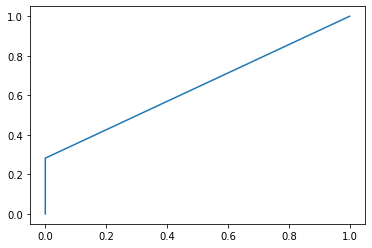

In [161]:
#test_fpr,test_tpr, test_thresholds = roc_curve(y_test, y_pred7)
# plt.plot(test_fpr, test_tpr)
# plt.show()



In [169]:
# get a classification 
diagnosis = ['normal', 'pneumonia']
classification_metrics7 = metrics.classification_report(y_test, y_pred7, target_names = diagnosis)
print(classification_metrics7)

              precision    recall  f1-score   support

      normal       0.69      1.00      0.81        61
   pneumonia       1.00      0.28      0.44        39

    accuracy                           0.72       100
   macro avg       0.84      0.64      0.63       100
weighted avg       0.81      0.72      0.67       100



Calculating the Fm score. We need to consider the cost of our mistakes within the model we have built through thresholdhold selection 
We will also be calculating the m, in order to get this we will calculate prevalence of each of the confusion matrices.


*** False Positive is going to be calculated by the cost of an x-ray, a consultation and medication. 
An x-ray here in the US costs about $370 https://health.costhelper.com/x-rays.html ***
*** A consultation is about $250 (On the NHS, this is the cost constructed that is free for patients but overall in terms of budget https://bit.ly/3cafM5n *** 
*** Prescriptions are $23.99 but with a coupon (pharmacists typically scan a coupon on hand for you this will be a total of $5.06 https://www.google.com/search?q=cost+of+amoxicillin+without+insurance+usa&rlz=1C5CHFA_enGB891GB891&oq=cost+of+amoxicillin+without+insurance+usa&aqs=chrome..69i57.9555j0j7&sourceid=chrome&ie=UTF-8 ***

*** FP = 370 + 250 + 5.06 = 625.06 ***

*** True Negative Cost *** This is the cost of when a child truly does not have pneumonia. Here we will still take the cost of the x-ray into account 
*** TNc = 250 ***

*** True Positive is when pediatric patients are correctly diagnosed with pneumonia *** 
*** Since children are at higher risk of pneumonia (they naturally have weaker immune systems) Economic cost of pneumonia is $109 million per year https://www.who.int/news-room/fact-sheets/detail/pneumonia for 66 countries, this price includes the antiobiotics and diagnostics ***
*** TP = 


*** False Negative is when pediatric patients are told they do not have pneumonia but in fact do have pneumonia ***
*** Untreated pneumonia leads to serious illness, hospitalization and even death ***
*** https://www.pinnaclecare.com/forms/download/Human-Cost-Financial-Impact-Whitepaper.pdf ***
*** At worst it will account for funeral costs, but the measure of a family member's life is immeasurable ***
https://www.lhlic.com/consumer-resources/average-funeral-cost/ $10,000 * .15 (rate of death in children under 5)
will estimate this to be 1,500 

In [163]:
prevalence = y_test/len(y_test)
print("Prevalence:", prevalence)
FPc = 625.06 
TNc = 250
TPc = 625.06
FNc = 1500
m = ((1- prevalence)/prevalence)*((FPc - TNc)/(FNc - TPc))
print("M:", m)
fm = test_tpr -m*test_fpr
print("FM:", fm)



Prevalence: [[0.  ]
 [0.01]
 [0.01]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.01]
 [0.01]
 [0.  ]
 [0.01]
 [0.01]
 [0.01]
 [0.  ]
 [0.01]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.01]
 [0.  ]
 [0.01]
 [0.  ]
 [0.  ]
 [0.01]
 [0.  ]
 [0.01]
 [0.  ]
 [0.  ]
 [0.01]
 [0.  ]
 [0.01]
 [0.  ]
 [0.01]
 [0.  ]
 [0.01]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.01]
 [0.01]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.01]
 [0.01]
 [0.01]
 [0.01]
 [0.  ]
 [0.  ]
 [0.01]
 [0.01]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.01]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.01]
 [0.  ]
 [0.01]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.01]
 [0.  ]
 [0.01]
 [0.  ]
 [0.  ]
 [0.01]
 [0.01]
 [0.  ]
 [0.01]
 [0.01]
 [0.  ]
 [0.01]
 [0.  ]
 [0.01]
 [0.01]
 [0.  ]
 [0.01]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.01]
 [0.  ]
 [0.01]
 [0.  ]
 [0.  ]]
M: [[     inf]
 [42.43827]
 [42.43827]
 [     inf]
 [     inf]
 [     inf]
 [42.43827]
 [42.43827]
 [     inf]
 [42.43827]
 [42.43827]
 [42.43827]
 [     inf]
 [42.43827]
 [     inf]
 [  

In [165]:
test_thresholds

array([2, 1, 0])

In [167]:
# df_fm = pd.DataFrame(data=fm, columns=['FM'])
# df_fm['Threshold'] = test_thresholds
# df_fm.sort_values('FM', ascending=False)

ValueError: Shape of passed values is (100, 3), indices imply (100, 1)

***What is better FN FP? 
Threshold selection with .3 is the best option here because it shows the least amount of false negatives. This means that the model is not very accurate and needs to continue to learn and train the images for proper classification ***